In [1]:
from expresso.pycas import *

In [2]:
f = Function('f',argc = 1)
g = Function('g',argc = 2)

x,y = symbols("x, y",type=Types.Real)
z = Symbol('z',type=Types.Complex)

In [3]:
import numpy as np

def my_function_python(x,y):
    return (abs(x)/(1+abs(y)))%1

my_function_ccode = '''
double myfunction(double x,double y){
    return fmod(abs(x)/(1+abs(y)),1);
}
'''

pycas_custom_function = custom_function("myfunction",
                                argc = 2,
                                python_function=my_function_python,
                                ccode = my_function_ccode,
                                return_type=Types.Real)

In [4]:
import numpy as np
npx,npy = np.meshgrid(np.linspace(-10, 10, 1001),np.linspace(-10, 10, 950))

In [5]:
snpx = array('np_x',npx+2*np.random.rand(*npy.shape))
p = parameter('p',1)

In [6]:
expr = piecewise((pi*snpx(sin(x)*cos(y)*1000,y*50),y>0),(e*pycas_custom_function(y-p*x,x+p*y)*10,True)) 
expr

piecewise(tuple(pi*np_x[ sin(x)*1e3*cos(y),50*y \right],y>0),tuple(CustomFunction(<expresso.pycas.functions.CustomFunctionData object at 0x1057df4d0>,y-p*x,p*y+x)*10*e,True))

In [7]:
fs_def = FunctionDefinition('f_single',(x,y),expr,return_type=Types.Real,parallel=False)
fp_def = FunctionDefinition('f_parallel',(x,y),expr,return_type=Types.Real,parallel=True)

In [8]:
clib = ccompile(fp_def,fs_def)

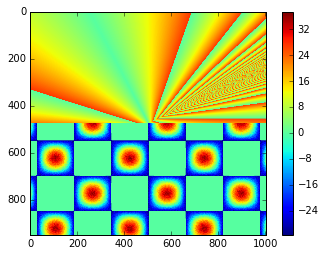

In [9]:
p.set_value(2)

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(clib.f_parallel(npx,npy))
plt.colorbar();

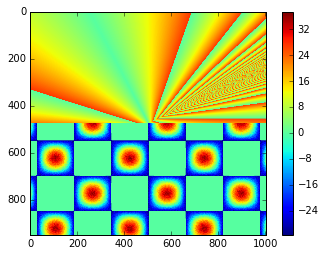

In [10]:
nlib = ncompile(fp_def,fs_def)
plt.imshow(nlib.f_parallel(npx,npy))
plt.colorbar();

In [11]:
#plt.imshow(nlib.f_single(npx,npy) - clib.f_parallel(npx,npy))
#plt.colorbar();
npx[ np.where(abs(nlib.f_parallel(npx,npy) - clib.f_parallel(npx,npy)) != 0) ],npy[ np.where(abs(nlib.f_parallel(npx,npy) - clib.f_parallel(npx,npy)) != 0) ]

(array([], dtype=float64), array([], dtype=float64))

In [12]:
lf = lambdify(expr)
N = mpmathify(expr)

for (vx,vy) in zip(10*(np.random.rand(1000)-0.5),10*(np.random.rand(1000)-0.5)):
    assert np.isclose(nlib.f_single(vx,vy),lf(x=vx,y=vy))
    assert np.isclose(lf(x=vx,y=vy),float(N(x=vx,y=vy)))

In [13]:
lib_f_single_t = clib.f_single(npx,npy)
lib_f_parallel_t = clib.f_parallel(npx,npy)
cf_single_t = nlib.f_single(npx,npy)
cf_parallel_t = nlib.f_parallel(npx,npy)

assert np.allclose(lib_f_single_t, lib_f_parallel_t)
assert np.allclose(cf_single_t, cf_parallel_t)
assert np.allclose(cf_parallel_t, lib_f_single_t)

In [14]:
%timeit nlib.f_single(npx,npy)

10 loops, best of 3: 91.1 ms per loop


In [15]:
%timeit nlib.f_parallel(npx,npy)

10 loops, best of 3: 58.2 ms per loop


In [16]:
%timeit clib.f_single(npx,npy)

10 loops, best of 3: 28.3 ms per loop


In [17]:
%timeit clib.f_parallel(npx,npy)

10 loops, best of 3: 16.9 ms per loop
